In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./part/DF1sthypTOT')

In [3]:
df.head()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,CountryCode,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Density,cnt
0,604.5970,51.276,AFG,1960,32.328512,4.000000e+07,739462.0,8255331.0,551.1210,2.252607e+10,13.891572,1928.0
1,160.4806,42.240,ALB,1960,62.254366,6.200000e+07,493982.0,1114818.0,151.0588,2.252607e+10,55.962154,4.0
2,373.1320,49.671,DZA,1960,46.135122,1.451501e+09,3394205.0,7730687.0,323.2800,2.252607e+10,4.670910,16.0
3,565.4100,54.423,AGO,1960,32.984829,1.451501e+09,550013.0,4720831.0,500.8860,2.252607e+10,4.227837,0.0
4,275.5520,32.920,ATG,1960,61.782732,1.451501e+09,21684.0,32997.0,244.9240,2.252607e+10,123.433409,0.0


In [4]:
del df['CountryCode']

In [5]:
df.dtypes

SP.DYN.AMRT.MA    float64
SP.DYN.CBRT.IN    float64
Year                int64
SP.DYN.LE00.IN    float64
MS.MIL.MPRT.KD    float64
SP.URB.TOTL       float64
SP.RUR.TOTL       float64
SP.DYN.AMRT.FE    float64
MilitaryExp       float64
Density           float64
cnt               float64
dtype: object

In [6]:
df.describe()

,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Density,cnt
count,9675.000000,9675.000000,9675.000000,9675.000000,9.675000e+03,9.675000e+03,9.675000e+03,9675.000000,9.675000e+03,9675.000000,9675.000000
mean,270.397297,30.040825,1986.390698,63.051208,8.126313e+08,1.151509e+07,1.518205e+07,199.607566,1.143548e+10,218.366585,77.351731
std,117.642358,13.020843,15.461280,11.333782,6.941853e+08,3.798078e+07,7.352284e+07,123.317763,2.374492e+10,1079.839746,296.719758
min,63.413000,6.900000,1960.000000,19.265512,0.000000e+00,6.627000e+03,0.000000e+00,29.171200,0.000000e+00,0.025899,0.000000
25%,182.181000,18.100000,1973.000000,54.847293,5.100000e+07,4.038695e+05,5.039915e+05,103.424500,1.425978e+08,15.926800,0.000000
50%,251.514000,30.063000,1986.000000,66.024927,9.780000e+08,1.994928e+06,2.519806e+06,159.363000,2.672286e+09,49.687727,0.000000
75%,341.427000,41.978500,2000.000000,71.670195,1.451501e+09,6.918278e+06,7.815200e+06,280.066500,2.252607e+10,117.831373,10.000000
max,921.630000,57.637000,2013.000000,83.831707,5.566000e+09,7.216918e+08,8.701360e+08,799.382000,6.980000e+11,20287.714286,2751.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31fdf709e8>,
      dtype=object)

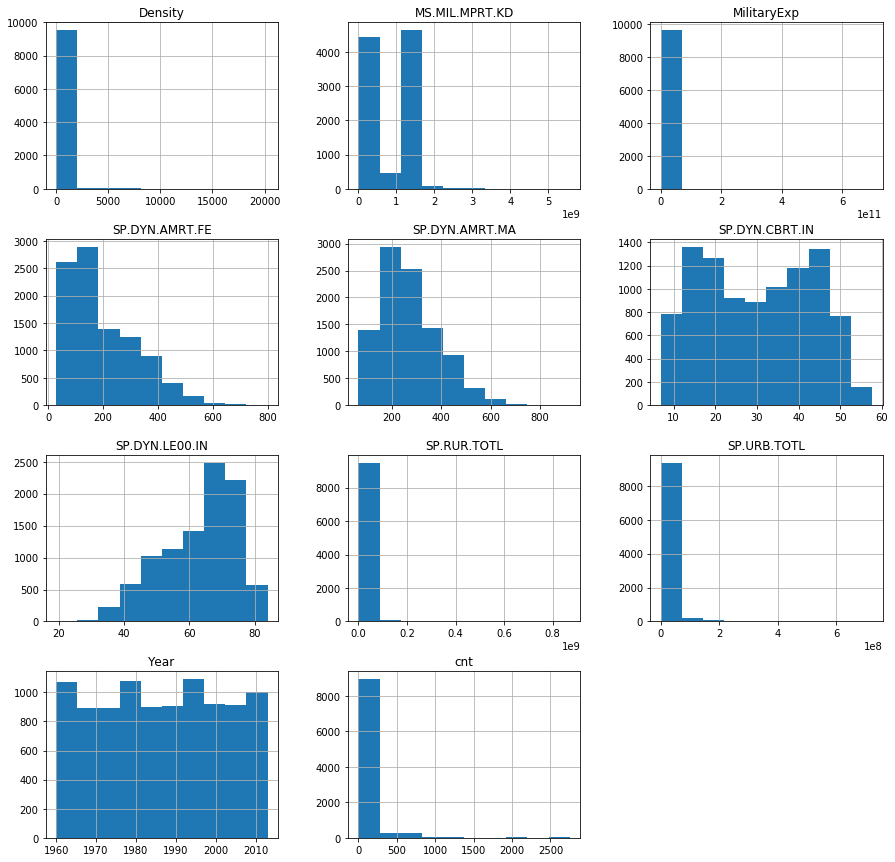

In [7]:
df.hist(figsize=(15,15))

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(df)
std_data = scaler.transform(df)
df_std= pd.DataFrame(std_data, index=df.index, columns=df.columns)
df_std.head()

/home/manuelz/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/manuelz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


,SP.DYN.AMRT.MA,SP.DYN.CBRT.IN,Year,SP.DYN.LE00.IN,MS.MIL.MPRT.KD,SP.URB.TOTL,SP.RUR.TOTL,SP.DYN.AMRT.FE,MilitaryExp,Density,cnt
0,2.840958,1.630945,-1.706978,-2.710859,-1.113062,-0.283727,-0.094217,2.850616,0.467096,-0.189367,6.237346
1,-0.934378,0.936944,-1.706978,-0.070310,-1.081369,-0.290191,-0.191341,-0.393709,0.467096,-0.150405,-0.247222
2,0.873325,1.507674,-1.706978,-1.492614,0.920363,-0.213827,-0.101353,1.002928,0.467096,-0.197906,-0.206777
3,2.507838,1.872646,-1.706978,-2.652948,0.920363,-0.288716,-0.142293,2.443233,0.467096,-0.198316,-0.260703
4,0.043819,0.221132,-1.706978,-0.111926,0.920363,-0.302627,-0.206056,0.367496,0.467096,-0.087919,-0.260703


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31fcc164e0>,
      dtype=object)

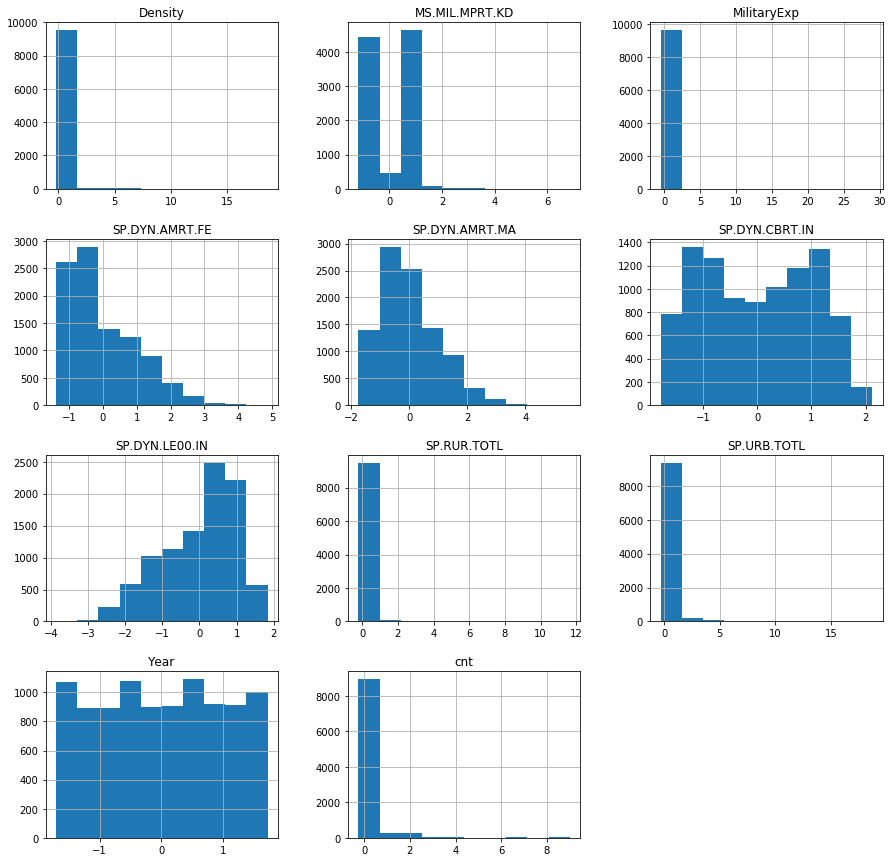

In [9]:
df_std.hist(figsize=(15,15))

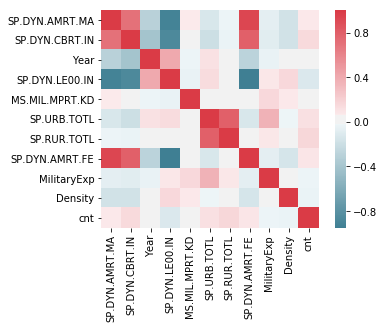

In [10]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [11]:
del df_std['SP.URB.TOTL']
del df_std['SP.DYN.AMRT.FE']
del df_std['SP.DYN.AMRT.MA']

#tolti a causa della collinearità


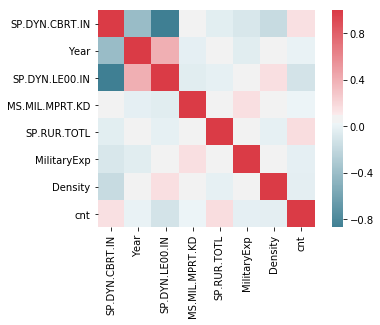

In [12]:
corr = df_std.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220,10, as_cmap=True), square=True)

In [13]:
from sklearn.model_selection import train_test_split

feature_matrix = df_std.loc[:, df_std.columns != 'cnt']
target_vector = df_std.cnt

x_train, x_test, y_train, y_test = train_test_split(feature_matrix, target_vector, test_size=0.2, random_state=1)

In [14]:
x_train.shape

(7740, 7)

In [15]:
x_test.shape

(1935, 7)

In [16]:
from sklearn.linear_model import LinearRegression

model=LinearRegression(fit_intercept=True)
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
y_pred_train = model.predict(x_train)

In [18]:
y_pred_test = model.predict(x_test)

In [19]:
from sklearn import metrics

R2_base = metrics.r2_score(y_train, y_pred_train, sample_weight=None, multioutput='uniform_average')
R2 = metrics.r2_score(y_test, y_pred_test, sample_weight=None, multioutput='uniform_average')

print("R2 on train: ", R2_base)
print("R2 on test: ", R2)

R2 on train:  0.06190613965444702
R2 on test:  0.0480543262675408


In [20]:
coefficients = pd.Series(model.coef_, index=x_train.columns)
print('Coefficients: ')
print(coefficients)

Coefficients: 
SP.DYN.CBRT.IN    0.242325
Year              0.064198
SP.DYN.LE00.IN    0.077813
MS.MIL.MPRT.KD    0.006264
SP.RUR.TOTL       0.186981
MilitaryExp      -0.019000
Density          -0.000560
dtype: float64


## Polynomial models applying k-Fold CV and Ridge regulatization

In [52]:
import numpy as np
from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures as pol
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from statistics import mean 
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=7, shuffle=True, random_state=2) # we are setting 7 folds
feature_matrix=df_std.loc[:, df_std.columns != 'cnt']
target_vector=df_std['cnt']
MSE_tr, MSE_te = [], []
kMSE_tr, kMSE_te = [],  []
degrees = [1,2,3,4] # list of different degrees of freedom
for degree in degrees: # cycle which applies the different degrees of freedom
    for train_index, test_index in kf.split(feature_matrix): # cycle that performs KCV on a certain polynomial model
        x_train, x_test = feature_matrix.iloc[train_index], feature_matrix.iloc[test_index]
        y_train, y_test = target_vector.iloc[train_index], target_vector.iloc[test_index]

        x_train = pd.DataFrame(scale(x_train), index=x_train.index, columns=x_train.columns) # standardization
        y_train = pd.DataFrame(scale(y_train), index=y_train.index).to_numpy() # standardization
        x_test = pd.DataFrame(scale(x_test), index=x_test.index, columns=x_test.columns) # standardization
        y_test = pd.DataFrame(scale(y_test), index=y_test.index).to_numpy() # standardization

        model = make_pipeline(pol(degree), RidgeCV(alphas=(0.01,1.0,100), cv=4))
        x = model.fit(x_train, y_train.ravel())
        y_pred_on_training=model.predict(x_train)
        y_pred=model.predict(x_test)
        MSE_tr.append(metrics.mean_squared_error(y_train, y_pred_on_training, sample_weight=None, multioutput='uniform_average'))
        MSE_te.append(metrics.mean_squared_error(y_test, y_pred, sample_weight=None, multioutput='uniform_average'))
    kMSE_tr.append(mean(MSE_tr))
    kMSE_te.append(mean(MSE_te))
    MSE_tr = []
    MSE_te = []
print('kMSE on training, from degree 1 to 4:\n', kMSE_tr)
print('\nkMSE on testing, from degree 1 to 4:\n', kMSE_te)

kMSE on training, from degree 1 to 4:
 [0.9406598434095642, 0.8311101002608967, 0.751935161059617, 0.6684236950992717]

kMSE on testing, from degree 1 to 4:
 [0.9409462532822028, 0.8998751564435606, 0.8047640209398597, 39.0927534826432]


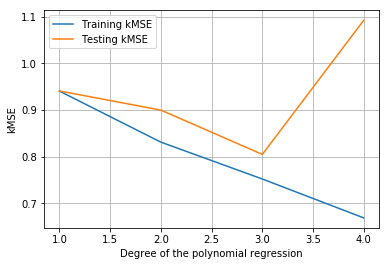

In [53]:
kMSE_te[3] = kMSE_te[3] - 38   # value decreased just to have a more readable plot
plt.plot(degrees, kMSE_tr, label='Training kMSE')
plt.plot(degrees, kMSE_te, label='Testing kMSE')
plt.xlabel('Degree of the polynomial regression')
plt.ylabel('kMSE')
plt.legend()
plt.grid()

plt.show()